# Going Deeper 04. Data Augmentation
--------
## [루브릭]

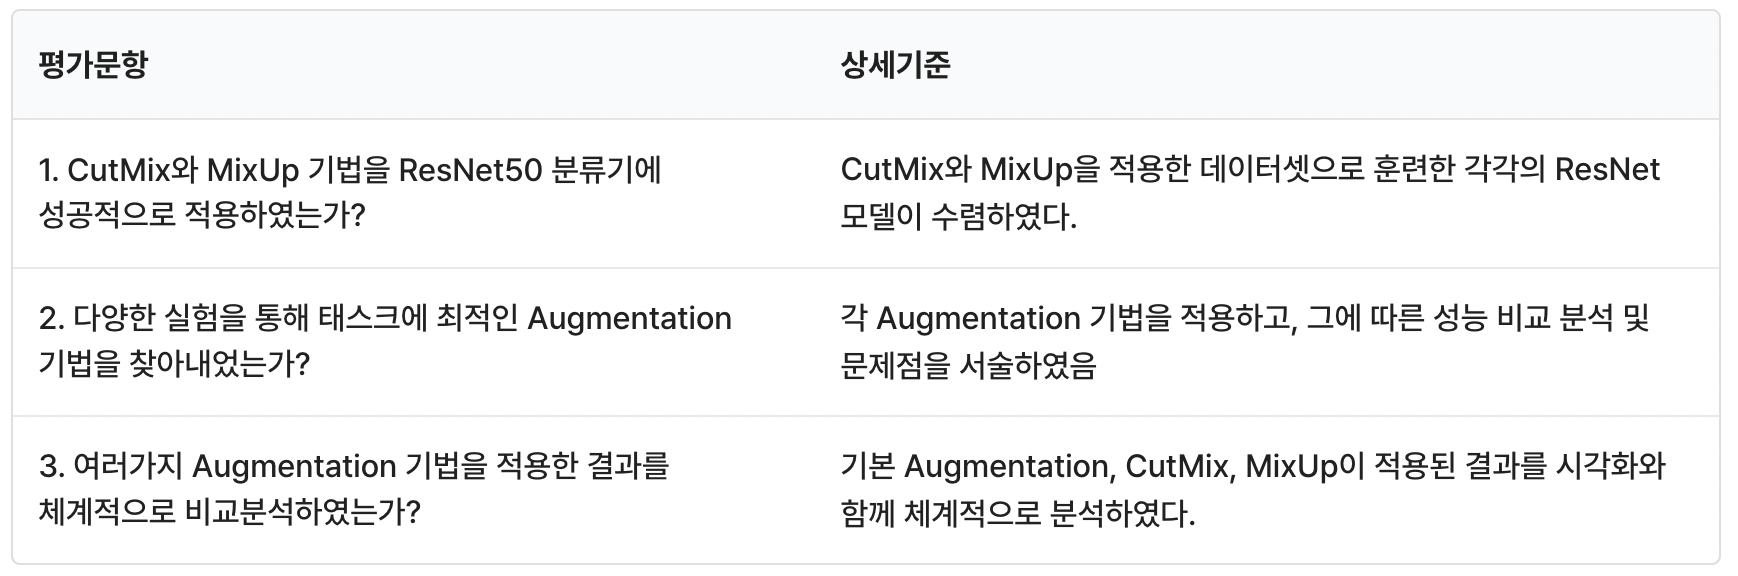

## Step 1 ResNet50 분류기로 Stanford Dogs 데이터 셋 분류해 보기

앞선 프로젝트에서 만들었던 ResNet50 모델을 활용하여 Augmentation 없이 Stanford Dogs 데이터 셋을 먼저 분류해 보겠습니다.

In [49]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [50]:
tf.keras.backend.clear_session()

In [51]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [52]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [53]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' ## 초기화할 GPU number

with tf.Graph().as_default():
	# GPU 메모리를 전부 할당하지 않고, 아주 적은 비율만 할당되어 시작됨. 프로세스의 메모리 수요에 따라 자동적으로 증가
	# 단, GPU 메모리를 처음부터 전체 비율을 사용하지 않음
	gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)

In [54]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [55]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [56]:
ds_info.features["label"].num_classes

120

In [57]:
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

In [58]:
sample = ds_train.take(1)
for example in sample:  
    print(example)

(<tf.Tensor: shape=(180, 160, 3), dtype=uint8, numpy=
array([[[133, 130, 113],
        [150, 149, 131],
        [184, 188, 171],
        ...,
        [ 65,  73,  75],
        [ 69,  77,  80],
        [ 73,  80,  86]],

       [[234, 231, 214],
        [215, 216, 198],
        [164, 168, 151],
        ...,
        [ 54,  62,  64],
        [ 55,  63,  66],
        [ 58,  65,  71]],

       [[157, 156, 138],
        [193, 194, 176],
        [145, 149, 132],
        ...,
        [ 59,  68,  67],
        [ 58,  66,  69],
        [ 60,  67,  73]],

       ...,

       [[ 94,  83,  77],
        [ 84,  73,  67],
        [ 75,  64,  58],
        ...,
        [156, 156, 156],
        [135, 135, 135],
        [123, 123, 123]],

       [[111, 100,  94],
        [ 71,  60,  54],
        [ 64,  53,  47],
        ...,
        [176, 176, 176],
        [153, 153, 153],
        [138, 138, 138]],

       [[ 87,  76,  70],
        [ 50,  39,  33],
        [ 44,  33,  27],
        ...,
        [180, 180, 1

총 class 갯수는 120개이며, 정수형으로 표시되어 있음을 확인할 수 있습니다.

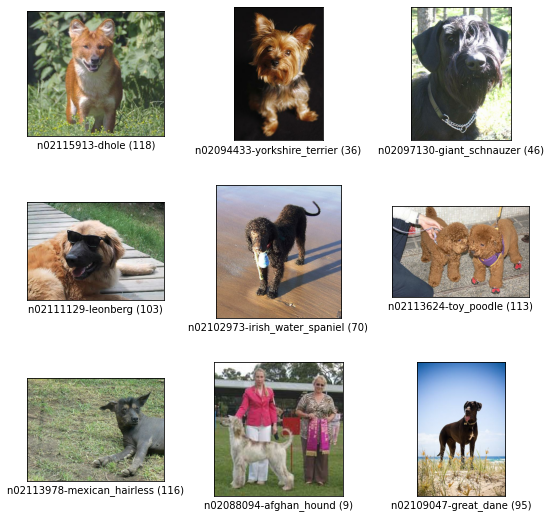

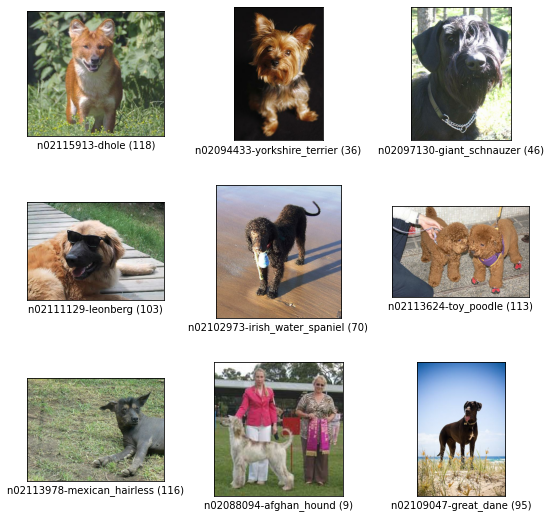

In [59]:
tfds.show_examples(ds_train, ds_info)

In [60]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


In [61]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [62]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [63]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [64]:
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

In [65]:
# is_50 : True => resnet_50
# is_plain : True => no skip connection
# original skip connection
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=0, is_50=False, is_plain=False):
    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    if not is_50:
        for cnn_num in range(num_cnn):
            shortcut = x
            if (block_num != 0) and (cnn_num == 0):
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=(2,2),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)

            else:
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)  

            x = keras.layers.BatchNormalization(name=f'block{block_num}_0_bn{cnn_num}')(x)
            x = keras.layers.Activation('relu', name=f'block{block_num}_0_relu{cnn_num}')(x)
            
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}')(x)
            x = keras.layers.BatchNormalization(name=f'block{block_num}_1_bn{cnn_num}')(x)
            
            if not is_plain:
                shortcut_channel = shortcut.shape.as_list()[-1]
                
                if (shortcut_channel != channel) and (block_num == 0) and (cnn_num == 0):
                    shortcut = keras.layers.Conv2D(channel, kernel_size=(1,1), strides=(1,1), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_2_bn{cnn_num}')(shortcut)                    
                    
                elif (shortcut_channel != channel) and (block_num != 0) and (cnn_num == 0):    
                    shortcut = keras.layers.Conv2D(channel, kernel_size=(1,1), strides=(2,2), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_2_bn{cnn_num}')(shortcut)                    
                    
                    
                # skip connection
                x = keras.layers.Add(name=f'block{block_num}_2_add{cnn_num}')([x, shortcut])
                x = keras.layers.Activation('relu', name=f'block{block_num}_2_relu{cnn_num}')(x)
            
            else:
                x = keras.layers.Activation('relu', name=f'block{block_num}_2_relu{cnn_num}')(x)
    
    else :
        for cnn_num in range(num_cnn):
            shortcut = x
            if (block_num != 0) and (cnn_num == 0):
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    strides=(2,2),
                    kernel_initializer='he_normal',
                    padding='valid',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)

            else:
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='valid',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)  
 
            x = keras.layers.BatchNormalization(name=f'block{block_num}_0_bn{cnn_num}')(x)
            x = keras.layers.Activation('relu', name=f'block{block_num}_0_relu{cnn_num}')(x)

            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}')(x)
            x = keras.layers.BatchNormalization(name=f'block{block_num}_1_bn{cnn_num}')(x)
            x = keras.layers.Activation('relu', name=f'block{block_num}_1_relu{cnn_num}')(x)

            x = keras.layers.Conv2D(
                filters=channel*4,
                kernel_size=(1,1),
                kernel_initializer='he_normal',
                padding='valid',
                name=f'block{block_num}_2_conv{cnn_num}')(x)
            x = keras.layers.BatchNormalization(name=f'block{block_num}_2_bn{cnn_num}')(x)        

            if not is_plain:
                shortcut_channel = shortcut.shape.as_list()[-1]

                if (shortcut_channel != channel*4) and (block_num == 0) and (cnn_num == 0):
                    shortcut = keras.layers.Conv2D(channel*4, kernel_size=(1,1), strides=(1,1), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_3_bn{cnn_num}')(shortcut)                    
                    
                elif (shortcut_channel != channel*4) and (block_num != 0) and (cnn_num == 0):    
                    shortcut = keras.layers.Conv2D(channel*4, kernel_size=(1,1), strides=(2,2), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_3_bn{cnn_num}')(shortcut)

                # skip connection
                x = keras.layers.Add(name=f'block{block_num}_3_add{cnn_num}')([x, shortcut])
                x = keras.layers.Activation('relu', name=f'block{block_num}_3_relu{cnn_num}')(x)

            else :
                x = keras.layers.Activation('relu', name=f'block{block_num}_3_relu{cnn_num}')(x)
        
    return x

In [66]:
resnet_input_layer = keras.layers.Input(shape=(224,224,3))   # 입력 레이어 생성
res_block_output = build_resnet_block(resnet_input_layer)    # resnet block 생성

In [67]:
def build_resnet(input_shape=(224,224,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=120, is_50=False, is_plain=False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # conv 1층
    output = keras.layers.Conv2D(filters=channel_list[0],
                                kernel_size=(7,7),
                                strides=(2,2),
                                padding='same',
                                kernel_initializer='he_normal')(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    
    # conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(output)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i, 
            is_50=is_50,
            is_plain=is_plain
        )
        
    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [68]:
resnet_50 = build_resnet(is_50=True)
resnet_50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [44]:
# from tensorflow.keras.utils import plot_model

# plot_model(resnet_50, show_shapes=True, to_file='resnet_50.png')

In [69]:
BATCH_SIZE = 64
EPOCH = 50

In [70]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
                                    learning_rate=0.001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    name='Adam'),
    metrics=['accuracy'],)

history_50 = resnet_50.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
187/187 [==============================] - 87s 225ms/step - loss: 4.9972 - accuracy: 0.0074 - val_loss: 4.7924 - val_accuracy: 0.0047
Epoch 2/50
187/187 [==============================] - 40s 212ms/step - loss: 4.7898 - accuracy: 0.0057 - val_loss: 4.7879 - val_accuracy: 0.0112
Epoch 3/50
187/187 [==============================] - 40s 213ms/step - loss: 4.7901 - accuracy: 0.0067 - val_loss: 4.7878 - val_accuracy: 0.0051
Epoch 4/50
187/187 [==============================] - 40s 215ms/step - loss: 4.7889 - accuracy: 0.0070 - val_loss: 4.7874 - val_accuracy: 0.0103
Epoch 5/50
187/187 [==============================] - 40s 215ms/step - loss: 4.7884 - accuracy: 0.0074 - val_loss: 4.7878 - val_accuracy: 0.0135
Epoch 6/50
187/187 [==============================] - 41s 219ms/step - loss: 4.7887 - accuracy: 0.0080 - val_loss: 4.7867 - val_accuracy: 0.0117
Epoch 7/50
187/187 [==============================] - 41s 218ms/step - loss: 4.7893 - accuracy: 0.0074 - val_loss: 4.7876 - val_ac

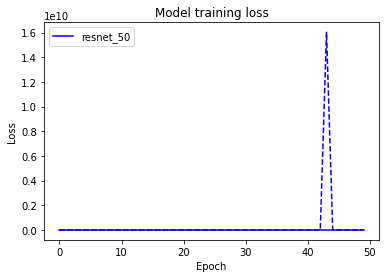

In [71]:
import matplotlib.pyplot as plt
plt.plot(history_50.history['loss'], 'b')
plt.plot(history_50.history['val_loss'], 'b--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50'], loc='upper left')
plt.show()

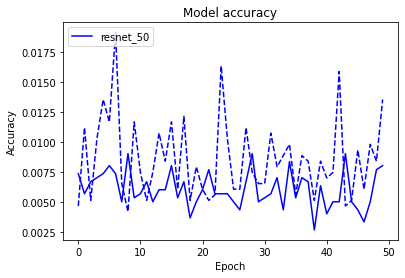

In [72]:
plt.plot(history_50.history['accuracy'], 'b')
plt.plot(history_50.history['val_accuracy'], 'b--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50'], loc='upper left')
plt.show()

직접 구성한 resnet50으로 학습을 한 결과 여전히 학습이 잘 진행되지 못하고 있습니다. 단순히 데이터의 문제는 아니었던 것으로 판단되며 모델 구조는 다시 한번 뜯어보고 고칠 필요가 있을 것 같습니다.    
일단 augmentation 실험을 위해 keras에서 지원하는 resnet50 모델을 불러와서 테스트를 해보겠습니다.

In [75]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(120, activation='softmax')
])

In [77]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
                                    learning_rate=0.001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    name='Adam'),
    metrics=['accuracy'],)

history50 = resnet50.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
187/187 [==============================] - 48s 215ms/step - loss: 4.8973 - accuracy: 0.0117 - val_loss: 5.7764 - val_accuracy: 0.0070
Epoch 2/50
187/187 [==============================] - 40s 214ms/step - loss: 4.7962 - accuracy: 0.0104 - val_loss: 4.8367 - val_accuracy: 0.0056
Epoch 3/50
187/187 [==============================] - 41s 218ms/step - loss: 4.7224 - accuracy: 0.0154 - val_loss: 5.1717 - val_accuracy: 0.0065
Epoch 4/50
187/187 [==============================] - 41s 221ms/step - loss: 4.6214 - accuracy: 0.0221 - val_loss: 4.8926 - val_accuracy: 0.0061
Epoch 5/50
187/187 [==============================] - 41s 221ms/step - loss: 4.5336 - accuracy: 0.0221 - val_loss: 14.5099 - val_accuracy: 0.0070
Epoch 6/50
187/187 [==============================] - 42s 224ms/step - loss: 4.4670 - accuracy: 0.0264 - val_loss: 4.6803 - val_accuracy: 0.0159
Epoch 7/50
187/187 [==============================] - 42s 224ms/step - loss: 4.4047 - accuracy: 0.0371 - val_loss: 6.1399 - val_a

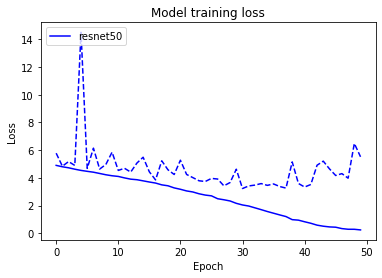

In [78]:
import matplotlib.pyplot as plt
plt.plot(history50.history['loss'], 'b')
plt.plot(history50.history['val_loss'], 'b--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50'], loc='upper left')
plt.show()

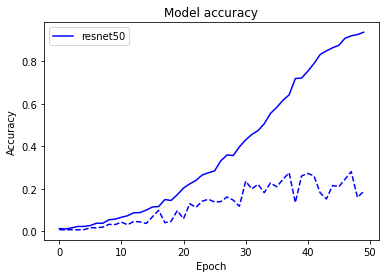

In [79]:
plt.plot(history50.history['accuracy'], 'b')
plt.plot(history50.history['val_accuracy'], 'b--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50'], loc='upper left')
plt.show()

데이터를 셔플했는데도 불구하고 training 데이터로는 학습이 진행되는 것으로 보이나, test 데이터의 결과는 여전히 좋지 않습니다. optimizer를 SGD로 변경해서 테스트를 추가로 진행해 보겠습니다. 

## 회고  
- summary 정보를 참고하여 resnet_50, resnet_34 모델을  레퍼런스 모델들과 동일한 형태로 구축해 보았습니다. 
- summary 내용으로 판단해 봤을 때는 이상한 부분을 찾지 못했으니 실제 학습결과 학습이 원활히 진행되지는 않았으며, loss 또한 34 보다 50모델이 더 크게 나왔습니다.  
- 참고를 위해 keras에서 지원하는 resnet50 모델과, resnet152 모델을 가져와서 학습을 해 본 결과 training set에서는 resnet152의 loss가 더 빨리 떨어지는 것을 확인했으나, validation set에서는 resnet50과 resnet152 모두 안정적인 결과를 보여주지는 못했습니다.   
- plain 모델 또한 resnet 모델과 비교하기 위해 build하여 학습을 수행했으나, resnet 모델과 동일하게 안정적인 결과를 보여주지 못했습니다.  
- 문제의 원인을 찾아 추가 개선이 필요하기에 일단 안정적인 결과가 나올 것으로 예상되는 imagenet 데이터로 다시 수행해보고 추가 개선을 추후 수행해 보도록 하겠습니다.    

[참고]  
- https://hwanny-yy.tistory.com/12  
- https://github.com/tensorpack/tensorpack/blob/master/examples/ResNet/resnet_model.py